In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from portfolio import Portfolio, Transaction

from files import read_stock_files, write_transaction_file, read_transaction_file
from trade import evaluate_transactions

In [2]:
transactions = read_transaction_file('../test_small.txt')

In [3]:
stocks_df = read_stock_files('../Stocks')

  0%|          | 0/7195 [00:00<?, ?it/s]

100%|██████████| 7195/7195 [00:17<00:00, 412.61it/s]


In [4]:
# drop stocks with less than a year of data
stocks_df = stocks_df.groupby('Name').filter(lambda x: len(x) >= 252)

# drop rows
stocks_df.drop(
    index=stocks_df.loc[
        (stocks_df[["Low", "High", "Open", "Close", "Volume"]] <= 0).any(axis=1) | 
        (stocks_df['Low'] > stocks_df['High']) | 
        (stocks_df['Volume'] < 10) | 
        (stocks_df['High'] > 10 * stocks_df['Low'])
    ].index,
    inplace=True,
)
stocks_df.drop(columns=["OpenInt"], inplace=True)
stocks_df.set_index(["Date", "Name"], inplace=True)
#stocks_df.sort_index(level="Date", ascending=True, inplace=True)


In [5]:
#stocks_df['IntraDayDiff_Volume'] = (stocks_df['High'] - stocks_df['Low']) * stocks_df['Volume'] * 0.1

In [6]:
grouped_by_stock = stocks_df.groupby(level=[1])

dff = pd.DataFrame({
    "HighClose": grouped_by_stock['Close'].max(),
    "DateHighClose": grouped_by_stock['Close'].idxmax().apply(lambda i: i[0]),
    "LowClose": grouped_by_stock['Close'].min(),
    "DateLowClose": grouped_by_stock['Close'].idxmin().apply(lambda i: i[0]),
})
dff['Diff'] = (dff['HighClose'] - dff['LowClose'])/dff['LowClose']
dff = dff.loc[dff['DateHighClose'] > dff['DateLowClose'] ]
#stonks = dff.sort_values(by='Diff', ascending=False).head(50) # change that
stonks_names = list(dff.sort_values(by='Diff', ascending=False).head(50).index)
stonks_names.append('ge')

In [7]:
# keep only stonks
stocks_df = stocks_df.loc[pd.IndexSlice[:, stonks_names], :].copy()
stocks_df.sort_index(level="Date", ascending=True, inplace=True)

In [8]:
stocks_df

Open      High       Low     Close   Volume
Date       Name                                                 
1962-01-02 ge      0.6277    0.6362    0.6201    0.6201  2575579
1962-01-03 ge      0.6201    0.6201    0.6122    0.6201  1764749
1962-01-04 ge      0.6201    0.6201    0.6037    0.6122  2194010
1962-01-05 ge      0.6122    0.6122    0.5798    0.5957  3255244
1962-01-08 ge      0.5957    0.5957    0.5716    0.5957  3696430
...                   ...       ...       ...       ...      ...
2017-11-10 unh   211.4600  211.8100  210.2000  211.0700  1384718
           utx   118.0000  118.4800  118.0000  118.1100  3122513
           uve    25.2500   25.4500   24.9500   25.2500   256504
           viav    8.4000    8.6100    8.3400    8.5500  5418048
           wmt    90.2400   91.6900   90.2000   90.9200  7646013

[384693 rows x 5 columns]

In [9]:
stocks_df['AllTimeMaxClose'] = stocks_df.groupby('Name')['Close'].transform('max')
stocks_df['AllTimeMinClose'] = stocks_df.groupby('Name')['Close'].transform('min')
stocks_df['AllTimeMaxCloseDate'] = stocks_df.index.get_level_values('Name').map(
    stocks_df.groupby('Name')['Close'].idxmax().map(lambda x: x[0])
)
stocks_df['AllTimeMinCloseDate'] = stocks_df.index.get_level_values('Name').map(
    stocks_df.groupby('Name')['Close'].idxmin().map(lambda x: x[0])
)


In [10]:
stocks_df['WantToSell'] = 0
stocks_df['WantToBuy'] = 0

stocks_df['PercentageIncrease'] = (stocks_df['Close'] - stocks_df['AllTimeMinClose'])/(stocks_df['AllTimeMaxClose'] - stocks_df['AllTimeMinClose'])
stocks_df.loc[stocks_df['PercentageIncrease'] > 0.6, 'WantToSell'] = 1
stocks_df.loc[stocks_df['PercentageIncrease'] < 0.1, 'WantToBuy'] = 1
""" 
stocks_df.loc[
    (
        pd.to_datetime(stocks_df['AllTimeMaxCloseDate'].max()) 
        - pd.to_datetime(stocks_df.index.get_level_values('Date'))
    ) / pd.Timedelta(days=1) < 1000, 'WantToSell'
] = 1 
"""


stocks_df.loc[stocks_df.index.get_level_values('Date') > stocks_df['AllTimeMaxCloseDate'], 'WantToBuy'] = 0
stocks_df.loc[stocks_df.index.get_level_values('Date') > stocks_df['AllTimeMaxCloseDate'], 'WantToSell'] = 1
stocks_df.loc[stocks_df.index.get_level_values('Date') < stocks_df['AllTimeMinCloseDate'], 'WantToBuy'] = 0
stocks_df.loc[stocks_df.index.get_level_values('Date') < stocks_df['AllTimeMinCloseDate'], 'WantToSell'] = 0

In [11]:
stocks_df

Open      High       Low     Close   Volume  \
Date       Name                                                    
1962-01-02 ge      0.6277    0.6362    0.6201    0.6201  2575579   
1962-01-03 ge      0.6201    0.6201    0.6122    0.6201  1764749   
1962-01-04 ge      0.6201    0.6201    0.6037    0.6122  2194010   
1962-01-05 ge      0.6122    0.6122    0.5798    0.5957  3255244   
1962-01-08 ge      0.5957    0.5957    0.5716    0.5957  3696430   
...                   ...       ...       ...       ...      ...   
2017-11-10 unh   211.4600  211.8100  210.2000  211.0700  1384718   
           utx   118.0000  118.4800  118.0000  118.1100  3122513   
           uve    25.2500   25.4500   24.9500   25.2500   256504   
           viav    8.4000    8.6100    8.3400    8.5500  5418048   
           wmt    90.2400   91.6900   90.2000   90.9200  7646013   

                 AllTimeMaxClose  AllTimeMinClose AllTimeMaxCloseDate  \
Date       Name                                                         
1962-01-02 ge             48.056          0.45902          2000-08-28   
1962-01-03 ge             48.056          0.45902          2000-08-28   
1962-01-04 ge             48.056          0.45902          2000-08-28   
1962-01-05 ge             48.056          0.45902          2000-08-28   
1962-01-08 ge             48.056          0.45902          2000-08-28   
...                          ...              ...                 ...   
2017-11-10 unh           212.870          0.26126          2017-11-03   
           utx           122.960          0.20553          2017-07-12   
           uve            34.076          0.02781          2015-10-23   
           viav          666.460          1.00060          2000-03-06   
           wmt            90.920          0.00821          2017-11-10   

                AllTimeMinCloseDate  WantToSell  WantToBuy  PercentageIncrease  
Date       Name                                                                 
1962-01-02 ge            1962-06-22           0          0            0.003384  
1962-01-03 ge            1962-06-22           0          0            0.003384  
1962-01-04 ge            1962-06-22           0          0            0.003218  
1962-01-05 ge            1962-06-22           0          0            0.002872  
1962-01-08 ge            1962-06-22           0          0            0.002872  
...                             ...         ...        ...                 ...  
2017-11-10 unh           1990-03-26           1          0            0.991534  
           utx           1970-07-06           1          0            0.960490  
           uve           2005-02-25           1          0            0.740779  
           viav          1994-04-19           1          0            0.011345  
           wmt           1974-12-06           1          0            1.000000  

[384693 rows x 12 columns]

<Axes: xlabel='None'>

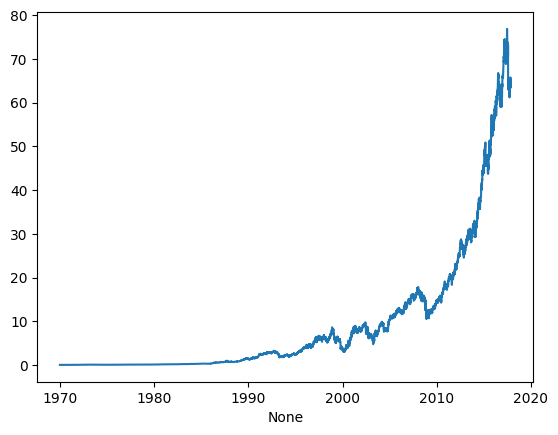

In [12]:
some_stock = stocks_df.query("Name == 'mo'")['Close']
x1, y1 = pd.to_datetime((some_stock.index.map(lambda x: x[0]))), some_stock.values

sns.lineplot(x=x1, y=y1)


<Axes: xlabel='None'>

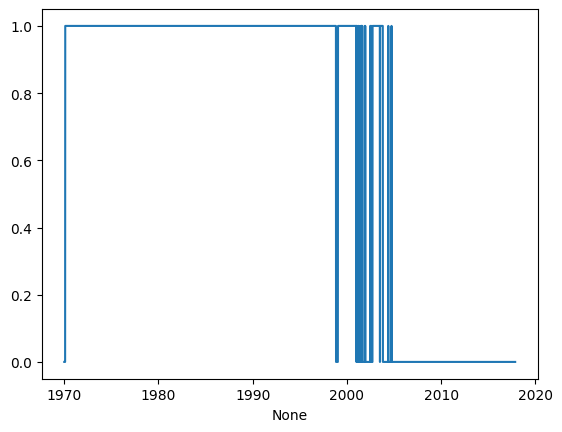

In [13]:
some_stock = stocks_df.query("Name == 'mo'")['WantToBuy']
#some_stock = stocks_df.query("Name == 'ge'")['WantToBuy']
x1, y1 = pd.to_datetime((some_stock.index.map(lambda x: x[0]))), some_stock.values

sns.lineplot(x=x1, y=y1)


In [14]:
# stocks_df['HighMinusClose'] = stocks_df["High"] - stocks_df["Close"] 
# stocks_df['OpenMinusLow'] = stocks_df["Open"] - stocks_df["Low"]

In [15]:
def handle_sell_open_to_rebuy_low(rows: pd.DataFrame, portfolio: Portfolio):
    trades: dict[str, tuple[int, float]] = dict()
    # rows contain stocks that I have and want to intraday trade
    for (_, stock_name), stock_info in rows.iterrows():
        how_many = min(
            portfolio.get_stocks().get(stock_name), int(0.1 * stock_info["Volume"])
        )
        save_money_to_rebuy = stock_info["Low"] * how_many
        trades[stock_name] = (how_many, save_money_to_rebuy)
    return trades


def handle_rebuy_low(sell_trades):
    return sell_trades


def handle_sell_high_to_rebuy_close(rows: pd.DataFrame, portfolio: Portfolio):
    trades: dict[str, tuple[int, float]] = dict()
    # rows contain stocks that I have and want to intraday trade
    for (_, stock_name), stock_info in rows.iterrows():
        how_many = min(
            portfolio.get_stocks().get(stock_name), int(0.1 * stock_info["Volume"])
        )
        save_money_to_rebuy = stock_info["Close"] * how_many
        trades[stock_name] = (how_many, save_money_to_rebuy)
    return trades


def handle_rebuy_close(sell_trades):
    return sell_trades


def handle_sell_high(rows: pd.DataFrame, portfolio: Portfolio):
    trades: dict[str, int] = dict()
    # rows contain stocks that I have and want to sell high forever
    for (_, stock_name), stock_info in rows.iterrows():
        how_many = min(
            portfolio.get_stocks().get(stock_name), int(0.1 * stock_info["Volume"])
        )
        trades[stock_name] = how_many
    return trades


def handle_buy_low(rows: pd.DataFrame, budget: float):
    # TODO: make the split more clever
    trades: dict[str, int] = dict()
    # split budget equally
    budget_each = budget / rows.shape[0]
    # print(f'Total budget {budget}: {rows.shape[0]}-way split; {budget_each} each')
    # rows contain stocks that want to buy
    for (_, stock_name), stock_info in rows.iterrows():
        how_many = min(
            int(budget_each / stock_info["Low"]), int(0.1 * stock_info["Volume"])
        )
        trades[stock_name] = how_many
    trades = {st: count for st, count in trades.items() if count > 0}
    return trades


def trade_2(df: pd.DataFrame, portfolio: Portfolio):
    end_of_time = pd.to_datetime(df["AllTimeMaxCloseDate"].max())
    """ pd.to_datetime(stocks_df['AllTimeMaxCloseDate'].max()) 
        - pd.to_datetime(stocks_df.index.get_level_values('Date')) """
    for day, stocks_today in df.groupby("Date"):
        sell_everything = (end_of_time - pd.to_datetime(day)) / pd.Timedelta(
            days=1
        ) < 1000

        sell_high_rebuy_close = (
            (stocks_today["Low"] == stocks_today["Close"])
            & (stocks_today["High"] > stocks_today["Low"])
            & (
                stocks_today.index.get_level_values("Name").isin(
                    portfolio.get_stocks().keys()
                )
            )
        ) & (~sell_everything)
        sell_open_rebuy_low = (
            (stocks_today["Open"] == stocks_today["High"])
            & (stocks_today["High"] > stocks_today["Low"])
            & (
                stocks_today.index.get_level_values("Name").isin(
                    portfolio.get_stocks().keys()
                )
            )
            & (~sell_high_rebuy_close)
            & (~sell_everything)
        )
        # this is an intraday only
        is_intraday_only = sell_high_rebuy_close.any() or sell_open_rebuy_low.any()

        # opening
        """ 
        At opening we sell all we can from sell_open_rebuy_low.
        Make sure to reserve some money to buy back
        """
        sell_open_buy_low_trades = handle_sell_open_to_rebuy_low(
            stocks_today.loc[sell_open_rebuy_low],
            portfolio,
        )
        # print("sell_open_buy_low_trades", sell_open_buy_low_trades)
        # execute open phase
        total_money_to_rebuy_on_low = 0
        for stock_name, (
            stock_count,
            money_to_rebuy,
        ) in sell_open_buy_low_trades.items():
            portfolio.sell(
                stocks_today.loc[(day, stock_name)], "sell-open", stock_count
            )
            total_money_to_rebuy_on_low += money_to_rebuy

        # miday
        money_to_spent_on_buy = portfolio.get_balance() - total_money_to_rebuy_on_low
        stocks_i_want_to_buy = (
            (stocks_today["WantToBuy"] == 1)
            & (stocks_today["Low"] < money_to_spent_on_buy)
            & (~is_intraday_only)
            & (~sell_everything)
        )

        buy_low_trades = (
            (
                handle_buy_low(
                    stocks_today.loc[stocks_i_want_to_buy],
                    money_to_spent_on_buy,
                )
            )
            if stocks_i_want_to_buy.any()
            else {}
        )
        # print("buy_low_trades", buy_low_trades)

        stocks_i_want_to_sell = (
            (stocks_today["WantToSell"] == 1)
            & (
                stocks_today.index.get_level_values("Name").isin(
                    portfolio.get_stocks().keys()
                )
            )
            & ~is_intraday_only
        )
        sell_high_trades = handle_sell_high(
            stocks_today.loc[stocks_i_want_to_sell],
            portfolio,
        )
        # print("sell_high_trades", sell_high_trades)

        buy_back_trades = handle_rebuy_low(sell_open_buy_low_trades)
        # print("buy_back_trades", buy_back_trades)

        sell_high_buy_close_trades = handle_sell_high_to_rebuy_close(
            stocks_today.loc[sell_high_rebuy_close],
            portfolio,
        )
        # print("sell_high_buy_close_trades", sell_high_buy_close_trades)

        # execute everything
        # buy low
        for stock_name, stock_count in buy_low_trades.items():
            portfolio.buy(stocks_today.loc[(day, stock_name)], "buy-low", stock_count)

        # sell high
        for stock_name, stock_count in sell_high_trades.items():
            portfolio.sell(
                stocks_today.loc[(day, stock_name)], "sell-high", stock_count
            )

        # rebuy low
        for stock_name, (stock_count, _) in buy_back_trades.items():
            portfolio.buy(stocks_today.loc[(day, stock_name)], "buy-low", stock_count)

        # sell high to rebuy close
        for stock_name, (stock_count, _) in sell_high_buy_close_trades.items():
            portfolio.sell(
                stocks_today.loc[(day, stock_name)], "sell-high", stock_count
            )

        # close phase rebuy on close
        for stock_name, (stock_count, _) in sell_high_buy_close_trades.items():
            portfolio.buy(stocks_today.loc[(day, stock_name)], "buy-close", stock_count)
        # print("\n")


portfolio = Portfolio()

# trade_2(stocks_df.query("Name == 'aapl'"), portfolio)
trade_2(stocks_df, portfolio)

In [16]:
print(portfolio.balance)
print(portfolio.get_stocks())
# 359659100427.766 0.1 0.6
# 359659100427.766 0.1 0.6 ksepoulima 1000

384023679377.9181
{'adbe': 69922}


In [17]:
#write_transaction_file('../test_ge.txt', portfolio.transaction_history) 
#write_transaction_file('../test_aapl.txt', portfolio.transaction_history) #  18451514975.311516
write_transaction_file('../test_large.txt', portfolio.transaction_history) # 233706764502.7446 

In [18]:
def plot_transaction_history(df: pd.DataFrame, transactions: list[Transaction]):
    portfolio = Portfolio()
    money = {}
    stocks = {}
    for transaction in transactions:
        row_df = df.loc[(transaction.day, transaction.stock)]
        if transaction.transaction_type.startswith("buy"):
            portfolio.buy(row_df, transaction.transaction_type, transaction.count)
        else:
            portfolio.sell(row_df, transaction.transaction_type, transaction.count)
        
        sum_transaction = 0
        
        for stonk_name, stonk_count in portfolio.get_stocks().items():
            try:
                sum_transaction += (df.loc[(transaction.day, stonk_name)]['Close'] * stonk_count)
            except Exception:
                continue
        money[transaction.day] = portfolio.get_balance()
        stocks[transaction.day] = sum_transaction
        
    return money, stocks

money, stocks = plot_transaction_history(stocks_df, portfolio.transaction_history)

<Axes: >

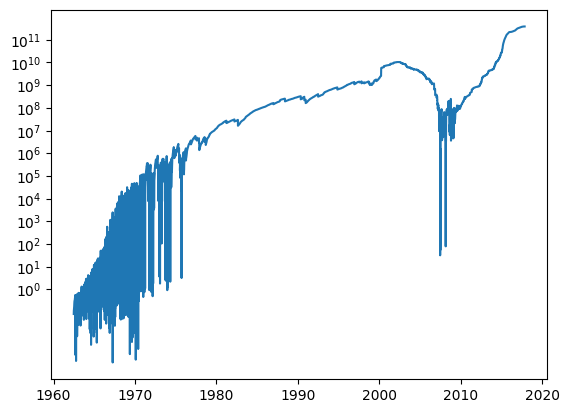

In [19]:
money_to_plot = pd.Series(list(money.values()), index=pd.to_datetime(list(money.keys())))
money_plot = sns.lineplot(money_to_plot)
money_plot.set_yscale("log")
money_plot.set_yticks(np.logspace(0, 11, num=12))
money_plot

<Axes: >

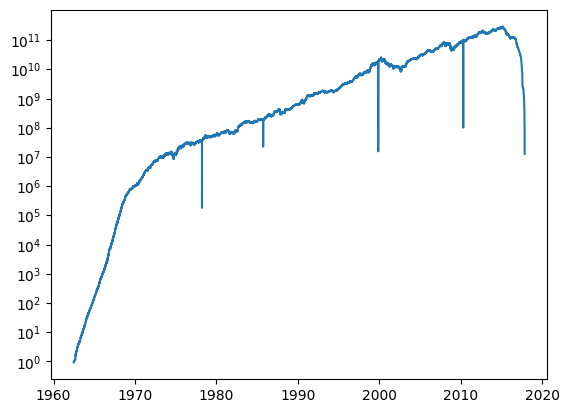

In [20]:
stock_to_plot = pd.Series(list(stocks.values()), index=pd.to_datetime(list(stocks.keys())))
stock_plot = sns.lineplot(stock_to_plot)
stock_plot.set_yscale("log")
stock_plot.set_yticks(np.logspace(0, 11, num=12))
stock_plot

In [4]:
portfolio = evaluate_transactions(stocks_df, transactions)
print(portfolio.get_balance()) # 570.371,72741 
print(portfolio.get_evaluation(stocks_df, '2017-11-01')) 

Transaction(day='1962-06-27', transaction_type='buy-low', stock='ge', count=2)
Open      4.590200e-01
High      4.669000e-01
Low       4.590200e-01
Close     4.669000e-01
Volume    2.122467e+06
Name: (1962-06-27 00:00:00, ge), dtype: float64
Transaction(day='1965-12-31', transaction_type='sell-high', stock='ge', count=2)
Open      9.903000e-01
High      9.984000e-01
Low       9.822000e-01
Close     9.822000e-01
Volume    2.444411e+06
Name: (1965-12-31 00:00:00, ge), dtype: float64
Transaction(day='1970-05-27', transaction_type='buy-low', stock='ge', count=4)
Open      5.074000e-01
High      5.313000e-01
Low       4.989200e-01
Close     5.233000e-01
Volume    6.546261e+06
Name: (1970-05-27 00:00:00, ge), dtype: float64
Transaction(day='1973-01-11', transaction_type='sell-high', stock='ge', count=4)
Open      1.223800e+00
High      1.264100e+00
Low       1.223800e+00
Close     1.223800e+00
Volume    5.729467e+06
Name: (1973-01-11 00:00:00, ge), dtype: float64
Transaction(day='1974-09-13'